In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

#### Here we define fits and variables

In [2]:
dt = .001 # Time differential

t0 =  0  # intial time
tF = 60  # final time
"""
{-536.349,{
B0->72.559,
dBG->0.0635991,
deltaB->0.236724,
deltaG->0.0982312,
deltaM->0.205638,
deltaP->0.151396,
dG->0.322589,
dM->0.00245009,
dP->0.0161013,
fM->11.0984,
hB->0.0000941496,
hG->1.68872*10^-11,
lambda->5.33041,
lambdaG->2.13481,
m->1.82175,
muG->1.2274*10^7,
rB->6.13599,
rG->0.274329,
sigmaA->0.135694,
sigmaN->0.391423}
}

"""
# Constants/fits emaileld
B0 = 72.559
d_BG = 0.0635991
delta_B = 0.236724
delta_G = 0.0982312
delta_M = 0.205638
delta_P = 0.151396
d_G = 0.322589
d_M = d_G #0.00245009 # should these have different values from d_G?
d_P = d_G #0.0161013  # does it make sense to have different values from d_G?
f_M = .5 
#f_M = 11.0984         # makes no sense that  f_M should be this high
h_B = 0.0000941496
h_G = 1.68872*(10**-11)
lam = 5.33041
lam_g = 2.13481
m = 1.82175
#mu = 1.2274*(10**7)  if mu is this high, model overflows
mu = 1
r_B = 6.13599
r_G = 0.274329

"""
# Constants/fits from writeup
lam = 1.64
B0 = 77.2
r_B = 6
r_G = 6
h_B = .14
delta_B = .11
h_G = .16
d_BG = .17
delta_G = 0
delta_P = .4
delta_M = .34
"""

# Sets if r_Gk is constant or if r_Gk = r_G*sqrt(k)
variabler_G = True

# Intial conditions
A0 = 1
A_g0 = 0

# the number of steps
N = int(round((tF-t0)/dt))


#### Here we set up the arrrays for approximating the model

In [21]:
Aarr = np.zeros(N + 1)
Aarr[0] = A0
A_garr = np.zeros(N + 1)
A_garr[0] = A_g0
Barr = np.zeros(N + 1)
Barr[0] = B0

Garr = np.zeros((4, N + 1))
Marr = np.zeros((4, N + 1))
Parr = np.zeros((4, N + 1))
    
Gtotarr = np.zeros(N + 1)
Mtotarr = np.zeros(N + 1)
Ptotarr = np.zeros(N + 1)

tarr = np.zeros(N + 1)
tarr[0] = t0


#### Here we have all the equations for the affinity model as laid out in the writeup

In [22]:
#Eqn 1
def dAdt(lam, m, A):
    return (-1 * (lam + m) * A)

#Eqn 2
def dA_gdt(lam_g, m, A, A_g):
    return ((m * A) - (lam_g * A_g))

#Eqn 3
def dBdt(r_B, h_B, delta_B, d_BG, A, B):
    return ((r_B * A * B)/(h_B + A)) - ((delta_B + d_BG) * B )

#Eqn 4 and 5
# k is the index on G
def dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1):
    if(variabler_G):
        r_Gk = r_G * math.sqrt(k)
        r_Gkmin1 = r_G * math.sqrt(k - 1)
    else:
        r_Gk = r_G
        r_Gkmin1 = r_G
    
    if(k == 1):
        return ((d_BG * B) + (((r_Gk) * (1 - d_G - mu) * A_g * G_k)/ (h_G + A_g)) - (delta_G * G_k))
    else: 
        return (((r_Gk  * (1 - d_G - mu) * A_g)/(h_G + A_g)) * G_k) + ((mu * r_Gkmin1 * A_g * G_kmin1) / (h_G + A_g)) - (delta_G * G_k)
    
#Eqn 6
def dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k):
    if(variabler_G):
        r_Gkmin1 = r_G * math.sqrt(k - 1)
    else:
        r_Gkmin1 = r_G
    
    return ((f_M * d_G * r_Gkmin1 * A_g * G_k) / (h_G + A_g)) - (delta_M * M_k)

#Eqn 7
def dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k):
    if(variabler_G):
        r_Gkmin1 = r_G * math.sqrt(k - 1)
    else:
        r_Gkmin1 = r_G
    
    return (((1 - f_M) * d_G * r_Gkmin1 * A_g * G_k) / (h_G + A_g)) - (delta_P * P_k)


#### The main function of the model. 
It utilizes the Euler method for approximating systems of differential equations:
https://en.wikipedia.org/wiki/Euler_method
There may be limitations (esp w/ small time steps) when using this method

In [23]:
# Euler method
def euler():
    for i in range(1, N + 1):
        #f_M = .5
        A = Aarr[i - 1]
        A_g = A_garr[i - 1]
        B = Barr[i - 1]
        t = tarr[i - 1]
        Aarr[i] = A + dt * dAdt(lam, m, A)
        A_garr[i] = A_g + dt * dA_gdt(lam_g, m, A, A_g)
        Barr[i] = B + dt * dBdt(r_B, h_B, delta_B, d_BG, A, B)
    
        for k in range(1, 4):
            #f_M = f_M * (2.71828 ** (.5 * (k - 1)))
            G_k = Garr[k, i - 1]
            G_kmin1 = Garr[k - 1, i - 1]
            P_k = Parr[k, i - 1]
            M_k = Marr[k, i - 1]
            Garr[k, i] = G_k + dt * dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1)
            # Question: does d_M/d_P not equal d_G?
            Parr[k, i] = P_k + dt * dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k)
            Marr[k, i] = M_k + dt * dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k)
            #print( Garr[k, i])
            Gtotarr[i] += Garr[k, i]
            Ptotarr[i] += Parr[k, i]
            Mtotarr[i] += Marr[k, i]
            
    
        tarr[i] = t + dt

#### Here, we extract expiremental data from csv's to plot w/ model

In [24]:
Scatter = pd.read_csv('data-Bcell-dynamics-edited-permouse.csv', index_col = 'day', names=['day','PB','GC','MCB'])
Stimes = Scatter.index.values[1:-1].astype('int')
Spb = Scatter.PB.values[1:-1].astype('double')
Sgc = Scatter.GC.values[1:-1].astype('double')
Smcb = Scatter.MCB.values[1:-1].astype('double')

#### Here, we run the model and graph the results

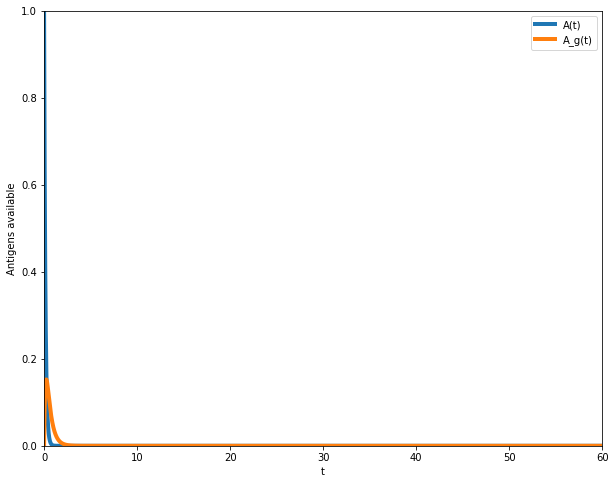

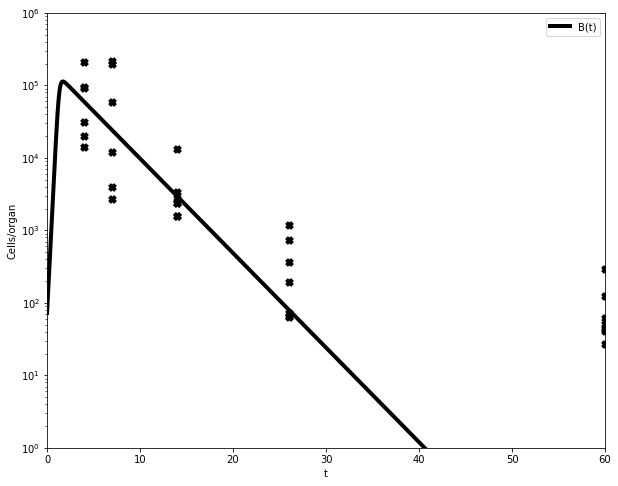

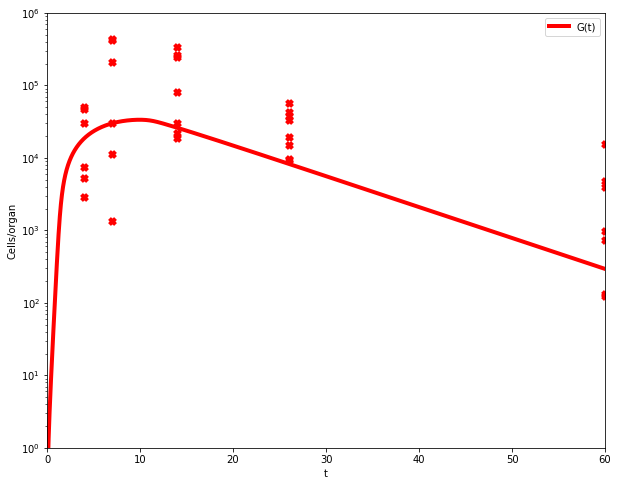

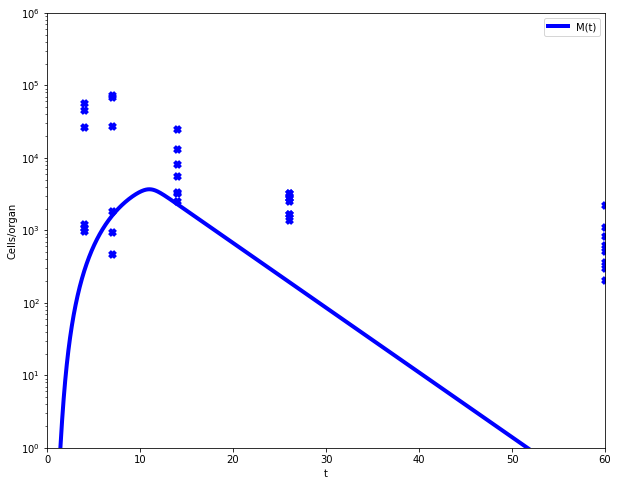

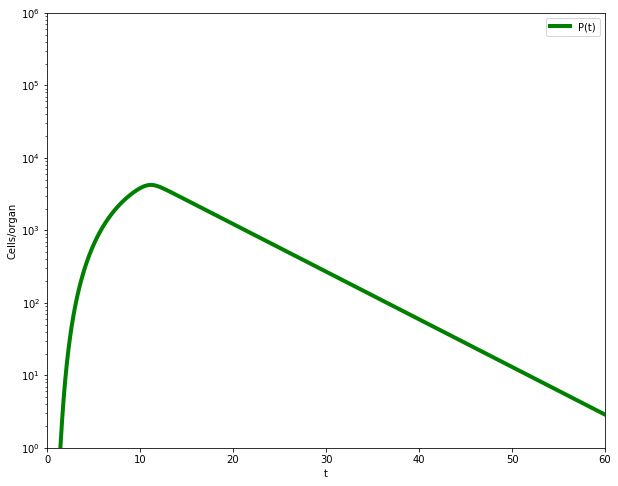

<function matplotlib.pyplot.show(close=None, block=None)>

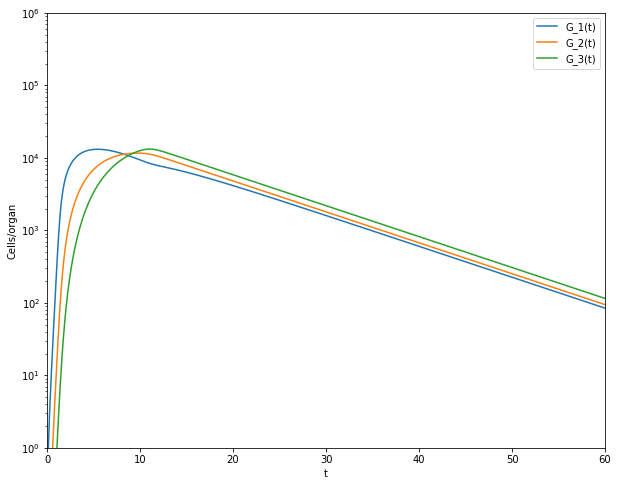

In [25]:
# Call the function to run the model so we can graph
euler()

# Graph of antigens available
fig1 = plt.figure()
fig1.set_size_inches(10,8)

plt.plot(tarr, Aarr, label = "A(t)", linewidth = 4)
plt.plot(tarr, A_garr, label = "A_g(t)", linewidth = 4)

plt.xlabel("t")
plt.ylabel("Antigens available")

plt.axis([t0, 60, 0, 1])

plt.legend()
plt.show()

#Plasmablasts graph

fig2 = plt.figure()
fig2.set_size_inches(10,8)

plt.plot(tarr, Barr, linewidth = 4, label = "B(t)", color = 'black')
plt.scatter(Stimes, Spb, linewidth = 4, marker = 'x', color = 'black')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# GC B cells graph

fig3 = plt.figure()
fig3.set_size_inches(10,8)

plt.plot(tarr, Gtotarr, linewidth = 4, label = "G(t)", color = 'red')
plt.scatter(Stimes, Sgc, linewidth = 4, marker = 'x', color = 'red')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# MCB cells graph

fig4 = plt.figure()
fig4.set_size_inches(10,8)

plt.plot(tarr, Mtotarr, linewidth = 4, label = "M(t)", color = 'blue')
plt.scatter(Stimes, Smcb, linewidth = 4, marker = 'x', color = 'blue')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Plasma cells graph

fig5 = plt.figure()
fig5.set_size_inches(10,8)

plt.plot(tarr, Ptotarr, linewidth = 4, label = "P(t)", color = 'green')
#plt.scatter(Stimes, Spc, linewidth = 4, marker = 'x', color = 'green')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Graph of GC B cell affinities 

fig6 = plt.figure()
fig6.set_size_inches(10,8)


plt.plot(tarr, Garr[1], label = "G_1(t)")
plt.plot(tarr, Garr[2], label = "G_2(t)")
plt.plot(tarr, Garr[3], label = "G_3(t)")
plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show
